In [1]:
#Charger le repertoire des scripts
import sys
import os
sys.path.append(os.path.abspath('./Library'))
import numpy as np
from matplotlib.pyplot import close, show
import matplotlib.pyplot as plt
import xarray as xr
from reef_models import reef_platform, reef, reef_eros
from tools import nlines
from tools_models import CheckSimu, ZarrName, shore
from Profile import Profile
from Dicts import Dicos
from datetime import datetime as dtime
from os import path
import xsimlab as xs
# to download xsimlab : pip install xarray-simlab


## Model input dataset

In [10]:
# %create_setup -v reef

dt = 200 # You can go up to 400 for detailed long simu, for a quick view, up to 1000
dico = Dicos()

# The first relevant parameters to test are : vertical__u, construct__Gm, hfactor__Dbar, eros__Ev.
# Remove the platform for the first tests I think, but if you prefer with one go ahead ! When you better see how the 4 
# parameters works, you can try another one, and bit by bit explore everything. If you want, at the end you can try also 
# to test "hfactor__how". But do not change the values of the other parameters in the "no need to test" part.

#SL = 'Bintanja2008-1000k.dat'
SL = 'Waelbroeck2002-137ky.dat'
# SL = 'Waelbroeck2002b.dat'
#SL = 'Holocene-SL.dat'
#SL = 'Grant2014-1000ky.dat'
#SL = 'Bintanja2005.dat'
tmax = nlines(dico.path_SLcurves+SL)*1e3
print(tmax)

ds_in = xs.create_setup(
    model=reef,
    clocks={
        'time' : np.arange(0., tmax+dt, dt),
},
    master_clock = 'time',
    input_vars={
        ## Usefull parameters to test. Everything in meters and years.
        # vertical land motion rate. [-10 - 2]e-3 (huge values, you can test before with 0.something e-3)
        'vertical__u': 0.5e-3,
        # initial slope of the substrate. [2 - 8]
        'grid__slopi': 6e-2,
        # maximum reef growth rate. [2 - 15]
        'construct__Gm': 6e-3,
        # maximum water height for reef growth. [10 - 50] 
        'construct__hmax':20,
        # width of wave action (controls the width of the coral reef). [10 - 3000] 
        'hfactor__Dbar': 100,
        # Eroded volume. [50 - 1000]e-3
        'eros__Ev': 60e-3,
        # Water height for wave base (the waves will start to erode at this depth). [1 - 10]
        'eros__hwb': 3.,
        # # Elevation of antecedent terrace. As you want, depends on vertical__u.
        # 'init__zterr': -20,
        # # Length of antecedent terrace. Put it to 0 if no platform, 10000 is already big
        # 'init__lterr': 3200,
        # # Terrace's slope
        # 'init__sloplat': 0.e-2,
        # # Sinus noise wavelength
        # 'init__wavelength' : 2500,
        # # Sinus amplitude
        # 'init__amplitude' : 10,
        ## No need to test 
        # Water height for open ocean
        'hfactor__how': 2,
        # uniform spacing
        'grid__spacing': 1,
        # filename for RSL reconstruction
        'SLstory__RSLin': SL,
        # I don't know.... 
        'grid__dmax': 20,
        # Coefficient for erosion efficiency, sea-bed
        'eros__beta1': 0.1,
        # Coefficient for erosion efficiency, cliff retreat
        'eros__beta2': 1,
        # Height of notch for volume eroded during cliff retreat
        'eros__hnotch': 1,
        # ---
        'depot__repos': 15e-2,
    },
    output_vars={
        'init__x'       : None,
        'profile__z'    : 'time',
        'sealevel__asl' : 'time',
        'profile__xmin' : None,
        'profile__xmax' : None,
        'depot__dS'     : 'time',
        'construct__dG' : 'time',
    }
)

#     output_vars={
#         'init__x'       : None,
#         'profile__z'    : None,
#         'sealevel__asl' : None,
#         'profile__xmin' : None,
#         'profile__xmax' : None,
#     }
# )

### The second set of outputs, with all set to "None", is to compute only the last profile. See below.


ds_in.attrs['model_name'] = 'reef'
ds_in.attrs['store'] = 'Profile'

139000.0


# Run

2024-10-03 15:43:20.619464
reef
./Outs/Zarr/Profiles/reef/reef_Profile_Waelbroeck2002-137ky.dat-u0.5-slopi6.0-Gm6.0-dmax20-hmax20-Dbar100-How2-Ev60.0-Hwb3.0-tmax139ky-dt200y.zarr
simu ./Outs/Zarr/Profiles/reef/reef_Profile_Waelbroeck2002-137ky.dat-u0.5-slopi6.0-Gm6.0-dmax20-hmax20-Dbar100-How2-Ev60.0-Hwb3.0-tmax139ky-dt200y.zarr
reef


/srv/conda/envs/notebook/lib/python3.10/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


Duration 0:00:26.365953
reef
WORK !!!
save


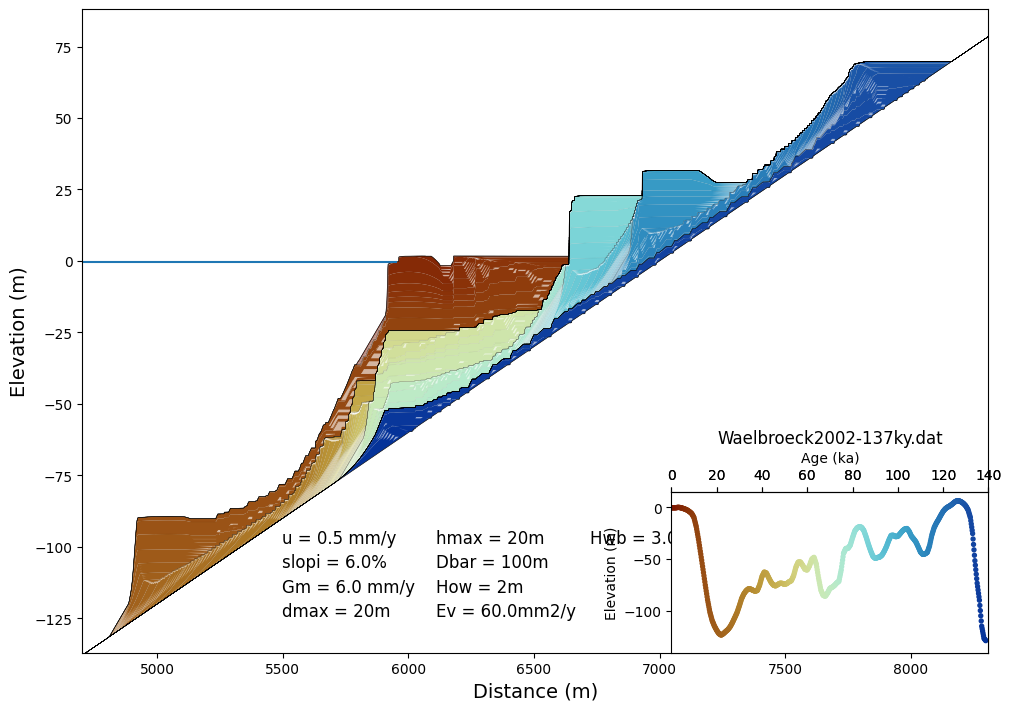

Duration 0:01:35.024723


In [11]:
# Code to compute and plot at each time step
              
t0=dtime.today()
print(t0)

# Running the simulation if it doesn't exist
if CheckSimu(ds_in, simu=True, view=True):
    ds = xr.open_zarr(ZarrName(ds_in))

    # Plotting figure
    fig = Profile(ds)
    fig.ProfileName('.png')

#                             # If the figure already exists, skip the iteration
    if path.exists(fig.namepath+fig.namefig):
        print('Done')
        close('all')

    fig.PlotProfile()
#                             fig.PlotData('DemoProfil.txt')
    fig.PlotASL()
    fig.WriteParams()

    print('save')
    fig.Savefig()
    show()
    close('all')
    print('Duration', dtime.today()-t0)


In [4]:
### Run cell to compute only the last profile (with outputs on "None,None,None...")

# from Dict_models import DicoModels

# t0=dtime.today()

# dm   = DicoModels()
# with dm.models[ds_in.model_name]:
#     ds_out = (ds_in   
#       .xsimlab.run()
#           )
# print('Duration', dtime.today()-t0)


In [5]:
### Plot the last profile, run the cell above firstly

# plt.plot(ds_out.profile__z)

# # # To zoom on the profile. First, let this commented, plot the profile and check where to zoom.
# # plt.xlim(4000,6000)
# # plt.ylim(-200,0)